# Homogenization

In this example, we demonstrate how to perform computational homogenization using the spectral solver framework. We will define a microstructure, apply macroscopic strains, and compute the effective material properties.

We will make use of the differentiable nature of `xpektra` to compute the tangent stiffness matrix via automatic differentiation using `JAX`.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import time
from functools import partial

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import Array
from skimage.morphology import disk

We start by importing the necessary libraries and configuring JAX for double-precision computations.

In [2]:
from xpektra import FFTTransform, SpectralOperator, SpectralSpace, make_field
from xpektra.projection_operator import GalerkinProjection
from xpektra.scheme import RotatedDifference
from xpektra.solvers.nonlinear import (  # noqa: E402
    NewtonSolver,
    conjugate_gradient,
)

## Define Microstructure

We define a simple microstructure consisting of a circular inclusion in a matrix material.

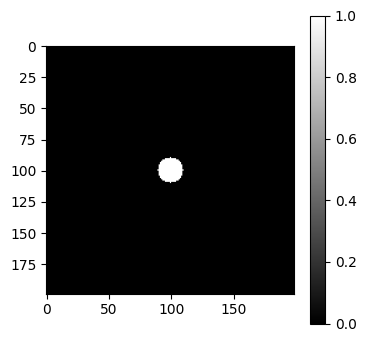

In [3]:
volume_fraction_percentage = 0.007

length = 0.1
H, L = (199, 199)

dx = length / H
dy = length / L

Hmid = int(H / 2)
Lmid = int(L / 2)
vol_inclusion = volume_fraction_percentage * (length * length)
r = (
    int(np.sqrt(vol_inclusion / np.pi) / dx) + 1
)  # Since the rounding off leads to smaller fraction therefore we add 1.

structure = jnp.zeros((H, L))
structure = structure.at[Hmid - r : Hmid + 1 + r, Lmid - r : Lmid + 1 + r].add(disk(r))

ndim = len(structure.shape)

plt.figure(figsize=(4, 4))
plt.imshow(structure, cmap="gray")
plt.colorbar()
plt.show()

## Define Material Properties

We assume the inclusion to be stiffer than the matrix.

In [4]:
# material parameters, lames constant
lambda_matrix = 2.0
mu_matrix = 1.0

lambda_inclusion = 10.0
mu_inclusion = 5.0

lambda_field = lambda_matrix * (1 - structure) + lambda_inclusion * (structure)
mu_field = mu_matrix * (1 - structure) + mu_inclusion * (structure)

## Defining Spectral functions

In [5]:
fft_transform = FFTTransform(dim=ndim)
space = SpectralSpace(
    lengths=(length,) * ndim, shape=structure.shape, transform=fft_transform
)
diff_scheme = RotatedDifference(space=space)

op = SpectralOperator(
    scheme=diff_scheme,
    space=space,
)

In [6]:
dofs_shape = make_field(dim=ndim, shape=structure.shape, rank=2).shape

In [7]:
@eqx.filter_jit
def strain_energy(eps_flat: Array) -> Array:
    eps = eps_flat.reshape(dofs_shape)
    eps_sym = 0.5 * (eps + op.trans(eps))
    energy = 0.5 * jnp.multiply(lambda_field, op.trace(eps_sym) ** 2) + jnp.multiply(
        mu_field, op.trace(op.dot(eps_sym, eps_sym))
    )
    return energy.sum()


compute_stress = jax.jit(jax.jacrev(strain_energy))

We now define the Galerkin projection operator.

In [8]:
Ghat = GalerkinProjection(scheme=diff_scheme)

In [9]:
@eqx.filter_jit
def residual_fn(eps_fluc_flat: Array, macro_strain: Array) -> Array:
    """
    A function that computes the residual of the problem based on the given macro strain.
    It takes only the flattened vector of fluctuation strain and a macro strain.

    Args:
        eps_fluc_flat: Flattened vector of fluctuation strain.
        macro_strain: Macro strain.

    Returns:
        Residual field.
    """

    eps_fluc = eps_fluc_flat.reshape(dofs_shape)
    eps_macro = jnp.zeros(dofs_shape)
    eps_macro = eps_macro.at[:, :, 0, 0].set(macro_strain[0])
    eps_macro = eps_macro.at[:, :, 1, 1].set(macro_strain[1])
    eps_macro = eps_macro.at[:, :, 0, 1].set(macro_strain[2] / 2.0)
    eps_macro = eps_macro.at[:, :, 1, 0].set(macro_strain[2] / 2.0)

    eps_total = eps_fluc + eps_macro
    eps_flat = eps_total.reshape(-1)
    sigma = compute_stress(eps_flat)
    residual_field = op.inverse(Ghat.project(op.forward(sigma.reshape(dofs_shape))))
    return jnp.real(residual_field).reshape(-1)


@eqx.filter_jit
def jacobian_fn(deps_flat: Array) -> Array:
    """
    The Jacobian is a linear operator, so its represents the Jacobian-vector product.
    For this linear elastic problem, we use the stress relation to compute the Jacobian.

    Args:
        deps_flat: The flattened displacement gradient field.

    Returns:
        The flattened Jacobian-vector product.
    """

    deps_flat = deps_flat.reshape(-1)
    dsigma = compute_stress(deps_flat)
    jvp_field = op.inverse(Ghat.project(op.forward(dsigma.reshape(dofs_shape))))
    return jnp.real(jvp_field).reshape(-1)

We can define a function to compute the local constitutive response given a macroscopic strain. The function will solve the local problem using a Newton-Krylov solver and return the homogenized stress.

In [10]:


@eqx.filter_jit
def local_constitutive_update(macro_strain):
    # set macroscopic loading to the residual
    # important for the implicit differentiation to work correctly
    # also, partial from functools and not from equinox
    residual_fn_partial = jax.jit(partial(residual_fn, macro_strain=macro_strain))

    # define the newton solver with the krylov solver
    solver = NewtonSolver(
        tol=1e-8,
        max_iter=20,
        krylov_solver=conjugate_gradient,
        krylov_tol=1e-8,
        krylov_max_iter=20,
    )

    # initialize the initial guess for the local strain field
    eps_init = jnp.array(make_field(dim=2, shape=structure.shape, rank=2))

    # solve for the fluctuation strain field, the residual is the
    # right hand side is defined based on the initial guess
    eps_fluc = solver.solve(
        x=eps_init.reshape(-1),
        f=residual_fn_partial,
        b=-residual_fn_partial(eps_init.reshape(-1)),
        jac=jacobian_fn,
    )

    # compute the actual micro strain field
    # eps fluctuation is added to the initial guess
    eps_macro = eps_init.at[:, :, 0, 0].set(macro_strain[0])
    eps_macro = eps_macro.at[:, :, 1, 1].set(macro_strain[1])
    eps_macro = eps_macro.at[:, :, 0, 1].set(macro_strain[2] / 2.0)
    eps_macro = eps_macro.at[:, :, 1, 0].set(macro_strain[2] / 2.0)

    eps = eps_fluc.reshape(dofs_shape) + eps_macro

    # compute the actual micro stress field
    sig = compute_stress(eps.reshape(-1)).reshape(dofs_shape)

    # get the macro stress
    macro_sigma = jnp.array(
        [
            jnp.sum(sig.at[:, :, 0, 0].get() * dx * dy),
            jnp.sum(sig.at[:, :, 1, 1].get() * dx * dy),
            0.5
            * (
                jnp.sum(sig.at[:, :, 1, 0].get() * dx * dy)
                + jnp.sum(sig.at[:, :, 0, 1].get() * dx * dy)
            ),
        ]
    )
    macro_sigma = macro_sigma / length**2

    return macro_sigma, (macro_sigma, sig, eps)

We use the `jax.jacfwd` to differentiate the stress computation function to obtain the tangent operator.

$$
\mathbb{C} = \frac{\partial \sigma(\varepsilon_\text{macro})}{\partial \varepsilon_\text{macro}}
$$

In [11]:
tangent_operator_and_state = jax.jacfwd(local_constitutive_update, has_aux=True)

In [12]:
deps = jnp.array([1.2, 1.0, 1])

start_time = time.time()
tangent, state = tangent_operator_and_state(deps)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Converged, Residual value : 6.819522211101115e-09
Time taken: 6.046091556549072 seconds


The homogenized tangent stiffness matrix is thus computed as:


In [13]:
print(f"tangent: {tangent}")

tangent: [[ 4.03381561e+00  2.01484013e+00 -3.93671797e-18]
 [ 2.01484013e+00  4.03381561e+00 -3.28159093e-18]
 [-7.00125670e-19  1.90780936e-18  1.00910293e+00]]


Plotting the micro stress field

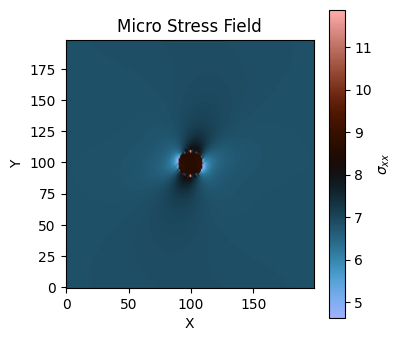

In [14]:
plt.figure(figsize=(4, 4))
plt.imshow(state[1][:, :, 0, 0], cmap="berlin", origin="lower")
plt.colorbar(label=r"$\sigma_{xx}$")
plt.title("Micro Stress Field")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()